In [1]:
import pandas as pd
import numpy as np
pd.options.display.float_format = '{:.5f}'.format

import matplotlib.pyplot as plt
from matplotlib import rc
%matplotlib inline
import seaborn as sns
rc('font', family='AppleGothic')
plt.rcParams['axes.unicode_minus'] = False
import warnings
warnings.filterwarnings(action = 'ignore')

In [2]:
# Model
from sklearn.linear_model import LogisticRegression

from xgboost import XGBClassifier
from xgboost import plot_importance

from sklearn.tree import DecisionTreeClassifier
# from sklearn.tree import export_graphviz
# import graphviz

from sklearn.svm import SVC

from sklearn.model_selection import GridSearchCV
from sklearn.preprocessing import StandardScaler, RobustScaler, QuantileTransformer
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, accuracy_score, recall_score, precision_score ,roc_auc_score, roc_curve
from sklearn.metrics import confusion_matrix
from imblearn.over_sampling import SMOTE, RandomOverSampler, ADASYN, BorderlineSMOTE
from imblearn.under_sampling import RandomUnderSampler, TomekLinks, OneSidedSelection
from sklearn.preprocessing import Binarizer

In [3]:
df_good = pd.read_csv('./dataset/data_확장기.csv')
df_bad = pd.read_csv('./dataset/data_수축기.csv')
df_change = pd.read_csv('./dataset/data_전환기.csv')
df_all = pd.read_csv('./dataset/data_전체.csv')

df_good.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)
df_bad.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)
df_change.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)
df_all.drop(['거래소코드', '회사명', '회계년도'], axis=1, inplace=True)

#### 함수

##### train, test 분리, 데이터 불균형 처리, 스케일링

In [4]:
def data(df):
    # scaler : StandardScaler(), RobustScaler()

    features = df.drop(['target'], axis=1)
    target = df['target']

    X_train, X_test, y_train, y_test = train_test_split(features, target, random_state=121, stratify=target, test_size=0.2)
    
    # X_train, y_train = RandomUnderSampler(random_state=121).fit_resample(X_train, y_train)
    # X_train, y_train = TomekLinks(sampling_strategy = 'not majority').fit_resample(X_train, y_train) # not majority(Good), majority, all
    # X_train, y_train = OneSidedSelection(sampling_strategy = 'auto', random_state=0, n_neighbors=1).fit_resample(X_train, y_train)

    # X_train, y_train = BorderlineSMOTE(random_state=121, sampling_strategy = 'not majority').fit_resample(X_train, y_train)
    # X_train, y_train = ADASYN(random_state=121).fit_resample(X_train, y_train)
    X_train, y_train = SMOTE(sampling_strategy = 'auto', random_state=121).fit_resample(X_train, y_train)

    scaler = StandardScaler()
    X_train = scaler.fit_transform(X_train)
    X_test = scaler.transform(X_test)
    
    return X_train, X_test, y_train, y_test

##### 모델 평가

In [5]:
def score(y_test, pred):
    
    print('accuracy score : {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('precision score : {0:.3f}'.format(precision_score(y_test, pred)))
    print('recall score : {0:.3f}'.format(recall_score(y_test, pred)))
    print('f1 score : {0:.3f}'.format(f1_score(y_test, pred)))
    print('roc score : {0:.3f}'.format(roc_auc_score(y_test, pred)))
    
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap='YlOrBr', fmt='g')
    plt.xlabel('Predicted', fontsize=20)
    plt.ylabel('Actual', fontsize=20)

In [6]:
def get_f1_score(y_test, pred_proba_1):
    thresholds = [0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9]
    accuracys = []
    precisions = []
    recalls = []
    f1_scores = []
    auc_scores=[]

    for threshold in thresholds:
        binarizer = Binarizer(threshold = threshold)
        pred_proba = binarizer.fit_transform(pred_proba_1)

        accuracy = accuracy_score(y_test, pred_proba)
        precision = precision_score(y_test, pred_proba)
        recall = recall_score(y_test, pred_proba)
        f1score = f1_score(y_test, pred_proba)
        auc_score=roc_auc_score(y_test, pred_proba)

        accuracys.append(accuracy)
        precisions.append(precision)
        recalls.append(recall)
        f1_scores.append(f1score)
        auc_scores.append(auc_score)
    results = pd.DataFrame(data = {"Accuracy": accuracys, "Precision": precisions, "Recall": recalls, "F1 score": f1_scores,"Auc_Score":auc_scores}, index = thresholds)
    print(results)

##### 모델링

In [7]:
def LR(df):
    X_train, X_test, y_train, y_test = data(df)

    logistic = LogisticRegression()

    param_logit = {'penalty' : ['l1', 'l2'],
                   'C' : [0.001, 0.01, 0.1, 1, 10, 100],
                   'solver' : ['liblinear'],
                   'random_state' : [121],
                   'class_weight' : ['balanced']}

    gridsearch = GridSearchCV(logistic, param_grid = param_logit, cv=5, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))


    # model_coef = pd.Series(best_model.best_estimator_.regressor_.coef_[0], df.drop(['target']).columns).sort_values(ascending=False)
    # model_coef

In [8]:
def DT(df):
    X_train, X_test, y_train, y_test = data(df)

    dt = DecisionTreeClassifier()
    param_dt = { 'criterion' : ['entropy'],   #giny : 속도 더 빠름, #엔트로피 : 균형적인 트리
                    'splitter' : ['best'],
                    'random_state' : [121],
                    'max_depth' : [5, 6, 7],
                    'min_samples_split' : [3, 5],
                    'class_weight' : ['balanced']}
    
    gridsearch = GridSearchCV(dt, param_grid = param_dt, cv=5, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))

    return gridsearch.fit(X_train, y_train)

In [9]:
def SVM(df, kernel):
    X_train, X_test, y_train, y_test = data(df)

    svc = SVC()
    param_svc = {'C' : [0.1, 0.5, 1.0],
                    'kernel' : [kernel],
                    'gamma' : [0.01, 0.1, 1.0, 10.0],
                    'random_state' : [121],
                    'class_weight' : ['balanced']}
    
    gridsearch = GridSearchCV(svc, param_grid = param_svc, cv=5, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)

    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    pred = estimator.predict(X_test)
    # pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    # prediction = pd.concat([pred_probability, pred], axis = 1)
    # prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    # pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    # print(get_f1_score(y_test, pred_proba_1))

In [10]:
def XGB(df):
    X_train, X_test, y_train, y_test = data(df)

    xgb = XGBClassifier()
    param_xgb={'booster' :['gbtree'],
               'silent' : [1],
               'verbosity' : [0],
               'learning_rate' : [0.01, 0.05, 0.1],    # 나중에 한 번 더 확인
               'n_estimators' : [500],
               'min_child_weight' : [3, 5, 7],  ###
               'gamma' : [0.1, 1.0, 10.0],    ###
               'max_depth' : [4, 6],     ###
               'objective':['binary:logistic'],
               'colsample_bytree' : [0.6, 0.8],
               'colsample_bylevel' : [0.6, 0.8],
               'random_state' : [121],
               'scale_pos_weight' : [ len(df[df['target']==0])/len(df[df['target']==1]) ]
                }

    gridsearch = GridSearchCV(xgb, param_grid = param_xgb, cv=5, n_jobs=-1, scoring='f1', verbose=0, refit=True)
    gridsearch.fit(X_train, y_train)
    
    print('최적 파라미터\n', gridsearch.best_params_)
    print('학습 데이터 정확도 : ', gridsearch.best_score_)

    estimator = gridsearch.best_estimator_
    pred = pd.DataFrame(estimator.predict(X_test))
    # pred = estimator.predict(X_test)
    pred_probability = pd.DataFrame(estimator.predict_proba(X_test))
    print('\n예측 데이터 정확도')
    score(y_test, pred)

    prediction = pd.concat([pred_probability, pred], axis = 1)
    prediction.columns = ["Negative(0)", "Positive(1)", "y_pred"]
    pred_proba_1 = np.array(prediction["Positive(1)"]).reshape(-1, 1)
 
    print(get_f1_score(y_test, pred_proba_1))

#### Feature Selection

In [11]:
rfe_good = df_good[['유동비율', 'OCF', '총자본경상이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', '유형자산증가율', '순이익증가율', 'target']]
sfm_rf_good = df_good[['부채비율', 'OCF', '총자산이익률', '총자본경상이익률', '자기자본순이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', '순이익증가율', 'target']]
sfm_lr_good = df_good[['자기자본비율', '차입금의존도', '총자산이익률', '총자본경상이익률', '자기자본영업이익률', '매출원가율', '총자본회전율', '총자본증가율', '유형자산증가율', 'target']]
sfm_pi_good = df_good[['자기자본영업이익률', '총자본회전율', '총자산이익률', '총자본경상이익률', '순이익증가율', '자기자본회전율', '유동비율', 'OCF', 'target']]

In [12]:
rfe_bad = df_bad[['유동비율', 'OCF', '총자본경상이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', 'target']]
sfm_rf_bad = df_bad[['부채비율', 'OCF', '총자산이익률', '총자본경상이익률', '자기자본순이익률', '자기자본영업이익률', '총자본회전율', '자기자본회전율', '순이익증가율', 'target']]
sfm_lr_bad = df_bad[['자기자본비율', '유동비율', '차입금의존도', '자기자본영업이익률', '매출원가율', '총자본회전율', '자기자본회전율', '총자본증가율', '유형자산증가율', 'target']]
sfm_pi_bad = df_bad[['자기자본영업이익률', '총자본회전율', '총자본경상이익률', '총자산이익률', '순이익증가율', '자기자본회전율', '유동비율', 'OCF', 'target']]

#### 확장기

##### Recursive Feature Elimination

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8575117915437926

예측 데이터 정확도
accuracy score : 0.809
precision score : 0.339
recall score : 0.859
f1 score : 0.487
roc score : 0.831
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.56482    0.19203 0.97302   0.32075    0.74483
0.30000   0.67016    0.23559 0.94605   0.37724    0.79182
0.40000   0.75098    0.28602 0.90778   0.43499    0.82012
0.50000   0.80855    0.33944 0.85947   0.48668    0.83100
0.60000   0.84518    0.38372 0.76913   0.51201    0.81165
0.70000   0.86618    0.40967 0.60602   0.48887    0.75146
0.80000   0.87115    0.39421 0.41029   0.40209    0.66792
0.90000   0.87897    0.37155 0.21142   0.26949    0.58460
None


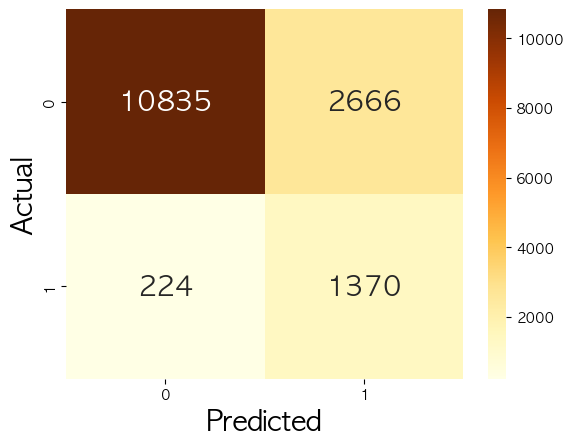

In [13]:
LR(rfe_good)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.919853237359274

예측 데이터 정확도
accuracy score : 0.873
precision score : 0.450
recall score : 0.908
f1 score : 0.602
roc score : 0.888
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.85028    0.41015 0.95358   0.57358    0.89583
0.30000   0.85386    0.41538 0.94228   0.57658    0.89285
0.40000   0.86896    0.44255 0.92785   0.59927    0.89493
0.50000   0.87320    0.45022 0.90778   0.60191    0.88845
0.60000   0.87453    0.44980 0.84316   0.58664    0.86070
0.70000   0.87956    0.45918 0.79046   0.58091    0.84027
0.80000   0.89082    0.48592 0.58469   0.53075    0.75583
0.90000   0.89122    0.48122 0.38582   0.42827    0.66836
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

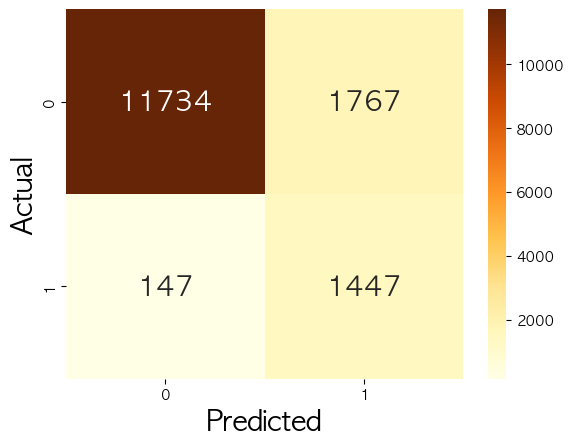

In [14]:
DT(rfe_good)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.9279855865118941

예측 데이터 정확도
accuracy score : 0.878
precision score : 0.458
recall score : 0.827
f1 score : 0.589
roc score : 0.856


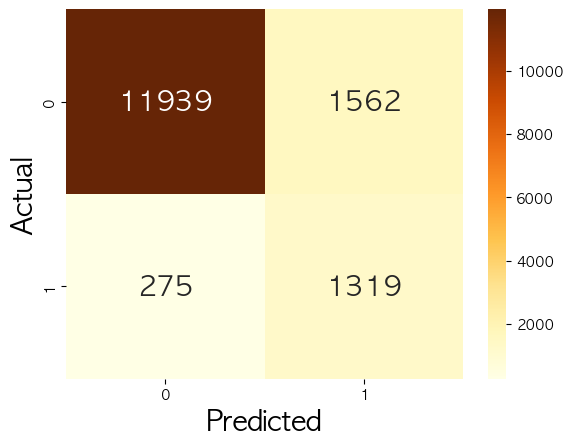

In [15]:
SVM(rfe_good, 'rbf')

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 7, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 8.467385850476669, 'silent': 1, 'verbosity': 0}
학습 데이터 정확도 :  0.9225806294217047

예측 데이터 정확도
accuracy score : 0.869
precision score : 0.444
recall score : 0.932
f1 score : 0.601
roc score : 0.897
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.84545    0.40390 0.97428   0.57106    0.90226
0.30000   0.85379    0.41682 0.96361   0.58193    0.90222
0.40000   0.86207    0.43060 0.94981   0.59256    0.90076
0.50000   0.86949    0.44381 0.93162   0.60121    0.89689
0.60000   0.87546    0.45514 0.91029   0.60686    0.89082
0.70000   0.88321    0.47163 0.88143   0.61448    0.88242
0.80000   0.89261    0.49499 0.83689   0.62206    0.86804
0.90000   0.90361    0.53169 0.73149   0.61579    0.82771
None


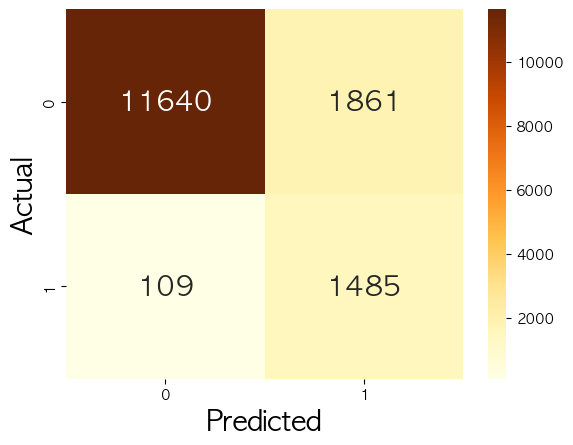

In [16]:
XGB(rfe_good)

##### SelectFromModel_RandomForest

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8576688178123586

예측 데이터 정확도
accuracy score : 0.809
precision score : 0.341
recall score : 0.863
f1 score : 0.488
roc score : 0.833
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.56502    0.19172 0.96989   0.32015    0.74355
0.30000   0.67075    0.23625 0.94856   0.37828    0.79325
0.40000   0.74872    0.28555 0.91844   0.43565    0.82357
0.50000   0.80908    0.34052 0.86261   0.48828    0.83268
0.60000   0.84869    0.38999 0.76725   0.51712    0.81278
0.70000   0.86731    0.41338 0.61230   0.49355    0.75486
0.80000   0.87360    0.40450 0.41719   0.41075    0.67234
0.90000   0.88129    0.38976 0.21957   0.28090    0.58949
None


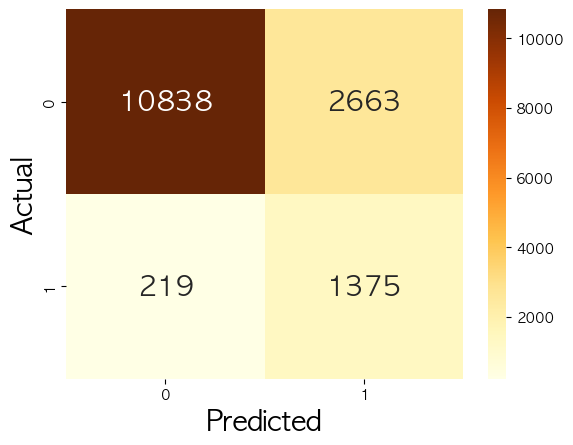

In [17]:
LR(sfm_rf_good)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.9193832237335945

예측 데이터 정확도
accuracy score : 0.873
precision score : 0.450
recall score : 0.902
f1 score : 0.600
roc score : 0.886
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.84902    0.40850 0.95922   0.57298    0.89762
0.30000   0.85194    0.41250 0.94793   0.57485    0.89427
0.40000   0.86910    0.44309 0.93287   0.60081    0.89722
0.50000   0.87320    0.44991 0.90151   0.60025    0.88568
0.60000   0.87850    0.45851 0.83187   0.59117    0.85794
0.70000   0.88042    0.46284 0.82434   0.59283    0.85569
0.80000   0.90255    0.53477 0.59348   0.56259    0.76626
0.90000   0.90354    0.54007 0.58344   0.56092    0.76239
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

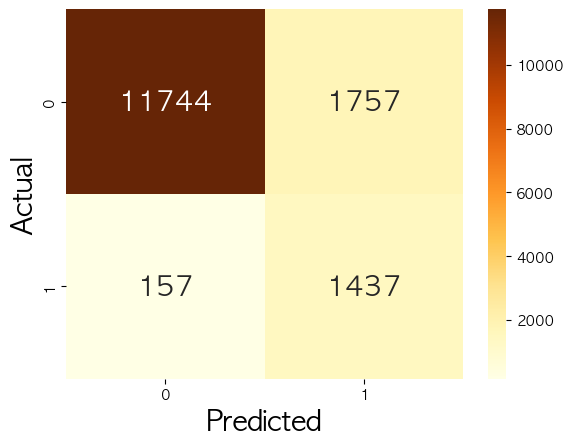

In [18]:
DT(sfm_rf_good)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.9299263056775265

예측 데이터 정확도
accuracy score : 0.884
precision score : 0.474
recall score : 0.842
f1 score : 0.606
roc score : 0.866


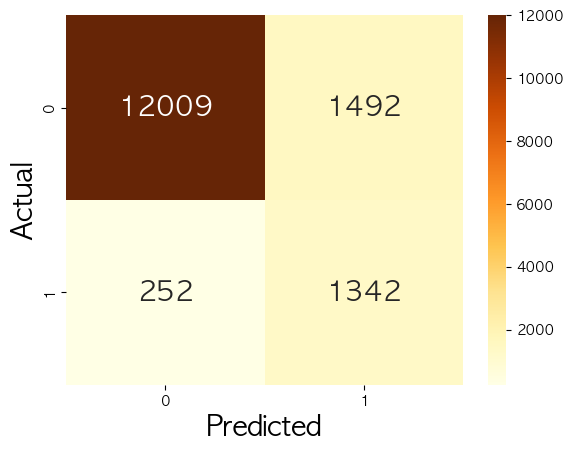

In [19]:
SVM(sfm_rf_good, 'rbf')

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 8.467385850476669, 'silent': 1, 'verbosity': 0}
학습 데이터 정확도 :  0.9222918155452617

예측 데이터 정확도
accuracy score : 0.867
precision score : 0.438
recall score : 0.935
f1 score : 0.597
roc score : 0.897
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.84233    0.39913 0.97553   0.56648    0.90107
0.30000   0.85220    0.41413 0.96361   0.57929    0.90133
0.40000   0.85936    0.42568 0.95044   0.58801    0.89952
0.50000   0.86671    0.43849 0.93476   0.59696    0.89672
0.60000   0.87261    0.44899 0.90841   0.60095    0.88839
0.70000   0.88042    0.46533 0.88833   0.61074    0.88391
0.80000   0.89089    0.49023 0.83438   0.61760    0.86597
0.90000   0.90374    0.53235 0.72773   0.61490    0.82613
None


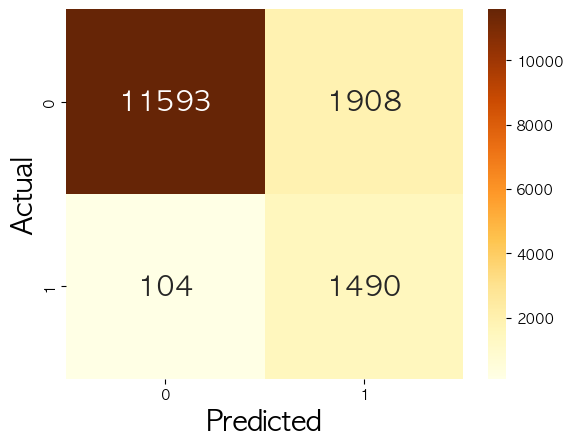

In [20]:
XGB(sfm_rf_good)

##### SelectFromModel_Logistic Regression

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8370122644241313

예측 데이터 정확도
accuracy score : 0.796
precision score : 0.322
recall score : 0.841
f1 score : 0.466
roc score : 0.816
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.52686    0.18019 0.98055   0.30444    0.72693
0.30000   0.65638    0.22875 0.95044   0.36875    0.78605
0.40000   0.74336    0.27967 0.90778   0.42760    0.81586
0.50000   0.79622    0.32196 0.84065   0.46560    0.81582
0.60000   0.83723    0.36768 0.75220   0.49392    0.79973
0.70000   0.86201    0.39851 0.60226   0.47964    0.74747
0.80000   0.86850    0.38466 0.40903   0.39647    0.66589
0.90000   0.87479    0.32989 0.18005   0.23295    0.56843
None


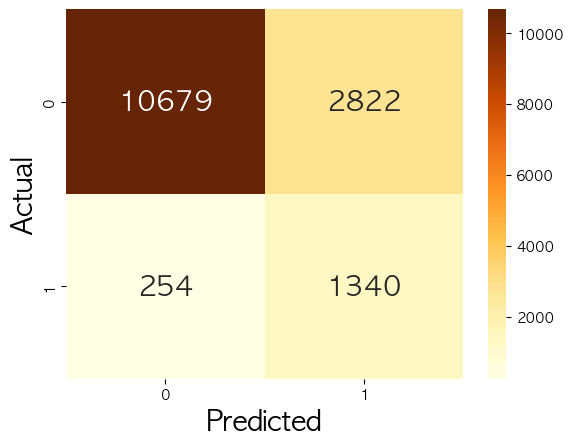

In [21]:
LR(sfm_lr_good)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.9032661822897371

예측 데이터 정확도
accuracy score : 0.830
precision score : 0.379
recall score : 0.950
f1 score : 0.542
roc score : 0.883
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.80954    0.35642 0.99749   0.52519    0.89242
0.30000   0.81000    0.35634 0.99122   0.52422    0.88991
0.40000   0.81033    0.35589 0.98306   0.52259    0.88650
0.50000   0.83034    0.37903 0.95044   0.54194    0.88330
0.60000   0.86592    0.43118 0.84504   0.57100    0.85671
0.70000   0.87141    0.44101 0.81368   0.57200    0.84595
0.80000   0.90441    0.53967 0.64429   0.58736    0.78970
0.90000   0.91381    0.61526 0.49059   0.54590    0.72719
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

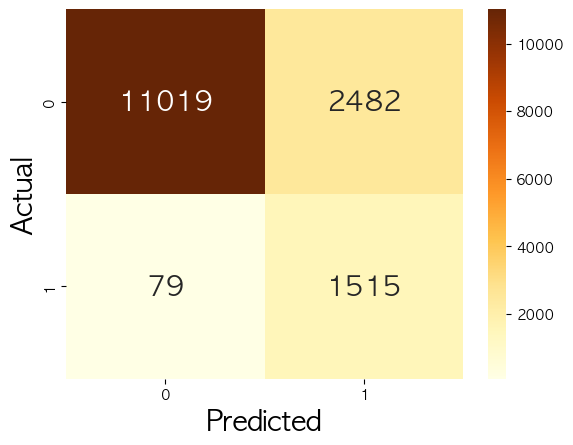

In [22]:
DT(sfm_lr_good)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 10.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.9495279580982245

예측 데이터 정확도
accuracy score : 0.900
precision score : 0.533
recall score : 0.420
f1 score : 0.470
roc score : 0.688


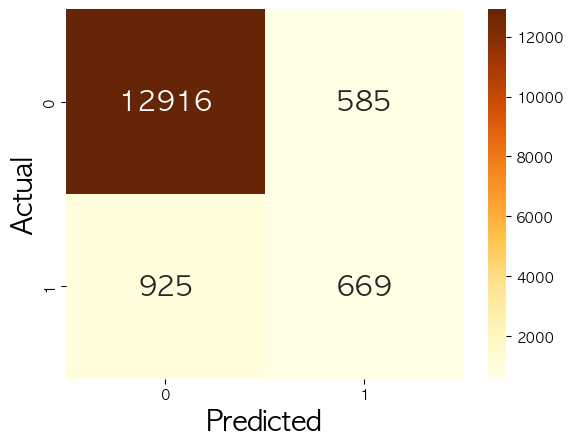

In [23]:
SVM(sfm_lr_good, 'rbf')

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 8.467385850476669, 'silent': 1, 'verbosity': 0}
학습 데이터 정확도 :  0.9169001071065624

예측 데이터 정확도
accuracy score : 0.841
precision score : 0.396
recall score : 0.959
f1 score : 0.560
roc score : 0.893
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.82597    0.37682 0.99122   0.54605    0.89884
0.30000   0.83067    0.38263 0.98369   0.55095    0.89815
0.40000   0.83551    0.38862 0.97302   0.55542    0.89615
0.50000   0.84114    0.39591 0.95922   0.56048    0.89321
0.60000   0.84796    0.40560 0.94479   0.56755    0.89066
0.70000   0.85611    0.41776 0.92095   0.57478    0.88470
0.80000   0.86817    0.43809 0.87892   0.58472    0.87291
0.90000   0.88831    0.48202 0.77353   0.59393    0.83769
None


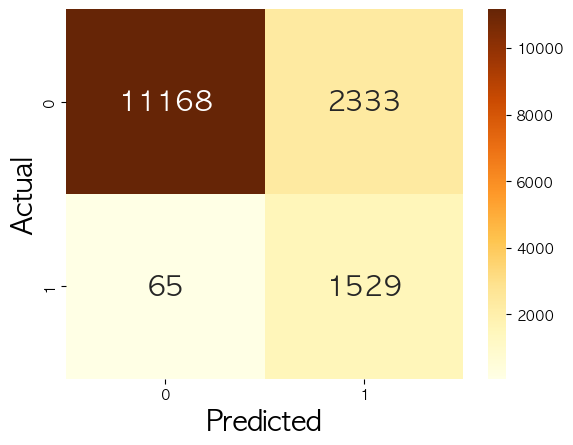

In [24]:
XGB(sfm_lr_good)

##### Permutation Importance

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8573179635006845

예측 데이터 정확도
accuracy score : 0.809
precision score : 0.340
recall score : 0.856
f1 score : 0.487
roc score : 0.830
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.56363    0.19152 0.97240   0.32002    0.74388
0.30000   0.67062    0.23552 0.94354   0.37694    0.79097
0.40000   0.75217    0.28662 0.90464   0.43532    0.81941
0.50000   0.80921    0.33989 0.85634   0.48663    0.82999
0.60000   0.84644    0.38580 0.76725   0.51343    0.81152
0.70000   0.86638    0.41004 0.60477   0.48872    0.75102
0.80000   0.87122    0.39445 0.41029   0.40221    0.66796
0.90000   0.87923    0.37701 0.22020   0.27802    0.58862
None


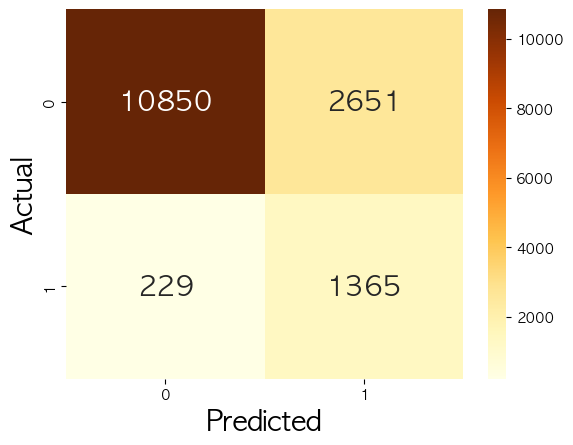

In [25]:
LR(sfm_pi_good)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.9195779644726259

예측 데이터 정확도
accuracy score : 0.873
precision score : 0.450
recall score : 0.911
f1 score : 0.602
roc score : 0.890
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.84750    0.40590 0.95797   0.57020    0.89621
0.30000   0.85306    0.41419 0.94479   0.57591    0.89351
0.40000   0.86764    0.44009 0.93099   0.59766    0.89557
0.50000   0.87287    0.44967 0.91092   0.60211    0.88965
0.60000   0.87413    0.44810 0.82873   0.58168    0.85411
0.70000   0.87956    0.45780 0.76223   0.57203    0.82782
0.80000   0.89460    0.50068 0.69636   0.58252    0.80718
0.90000   0.89122    0.48273 0.42095   0.44973    0.68385
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

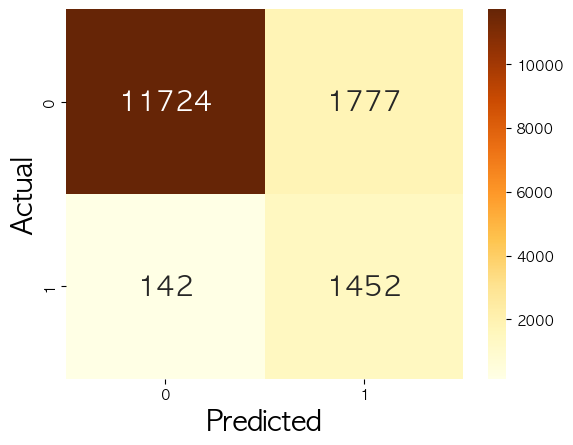

In [26]:
DT(sfm_pi_good)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.9244509860986412

예측 데이터 정확도
accuracy score : 0.875
precision score : 0.451
recall score : 0.851
f1 score : 0.590
roc score : 0.864


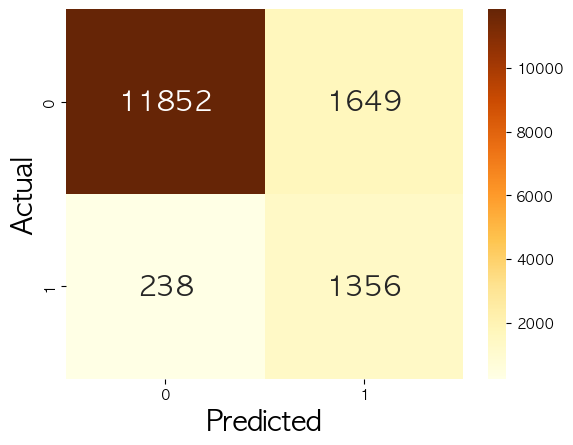

In [27]:
SVM(sfm_pi_good, 'rbf')

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 5, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 8.467385850476669, 'silent': 1, 'verbosity': 0}
학습 데이터 정확도 :  0.9220448227495952

예측 데이터 정확도
accuracy score : 0.866
precision score : 0.437
recall score : 0.936
f1 score : 0.596
roc score : 0.897
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.84121    0.39729 0.97428   0.56442    0.89989
0.30000   0.85134    0.41254 0.96173   0.57740    0.90002
0.40000   0.85942    0.42588 0.95169   0.58844    0.90011
0.50000   0.86598    0.43715 0.93601   0.59597    0.89686
0.60000   0.87353    0.45137 0.91719   0.60501    0.89278
0.70000   0.88175    0.46864 0.89523   0.61522    0.88769
0.80000   0.89135    0.49164 0.84818   0.62247    0.87232
0.90000   0.90189    0.52499 0.74467   0.61582    0.83256
None


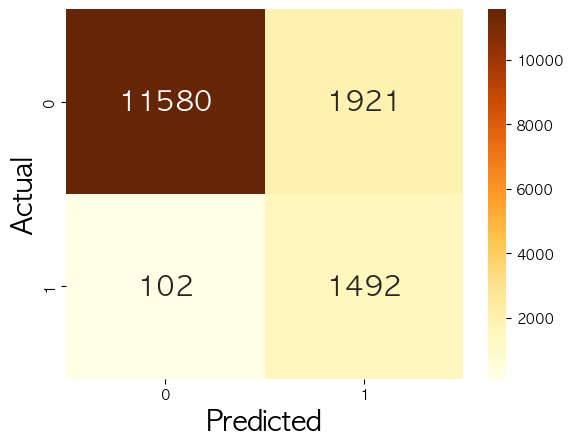

In [28]:
XGB(sfm_pi_good)

#### 수축기

##### Recursive Feature Elimination

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.846736359637033

예측 데이터 정확도
accuracy score : 0.775
precision score : 0.259
recall score : 0.879
f1 score : 0.400
roc score : 0.822
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.47062    0.13692 0.98487   0.24041    0.70384
0.30000   0.60472    0.17300 0.96471   0.29338    0.76798
0.40000   0.70893    0.21800 0.93613   0.35365    0.81197
0.50000   0.77527    0.25853 0.87899   0.39954    0.82231
0.60000   0.82659    0.30167 0.78992   0.43660    0.80996
0.70000   0.85618    0.30595 0.54454   0.39178    0.71485
0.80000   0.87191    0.28220 0.32773   0.30327    0.62512
0.90000   0.88835    0.21296 0.11597   0.15016    0.53806
None


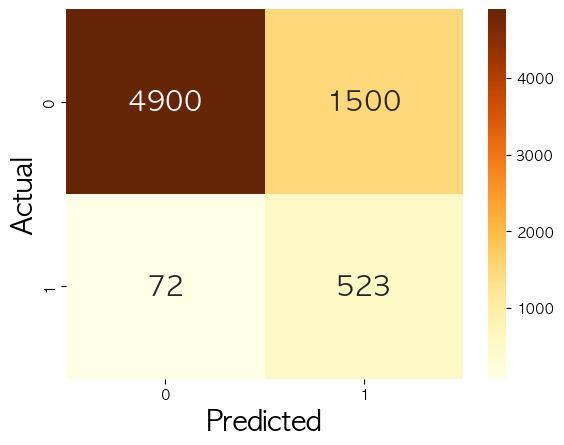

In [29]:
LR(rfe_bad)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.9030614031317772

예측 데이터 정확도
accuracy score : 0.829
precision score : 0.315
recall score : 0.855
f1 score : 0.460
roc score : 0.841
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.79900    0.28891 0.93277   0.44118    0.85967
0.30000   0.81916    0.30681 0.89412   0.45685    0.85315
0.40000   0.82573    0.31114 0.86387   0.45750    0.84303
0.50000   0.82916    0.31459 0.85546   0.46001    0.84109
0.60000   0.83960    0.32468 0.82017   0.46520    0.83079
0.70000   0.84560    0.32364 0.74790   0.45178    0.80129
0.80000   0.88077    0.36023 0.51765   0.42483    0.71609
0.90000   0.90765    0.41639 0.21345   0.28222    0.59282
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

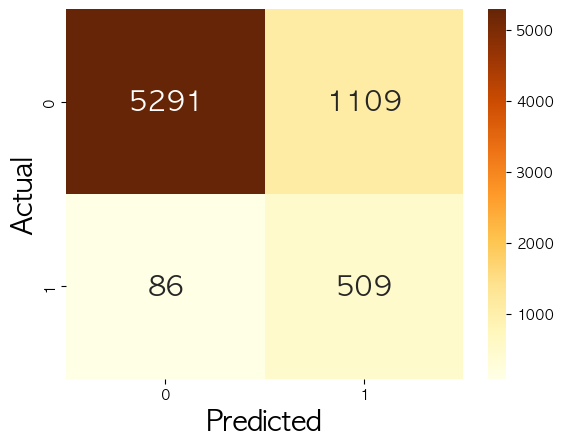

In [30]:
DT(rfe_bad)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 10.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.9117932386673939

예측 데이터 정확도
accuracy score : 0.872
precision score : 0.366
recall score : 0.686
f1 score : 0.477
roc score : 0.788


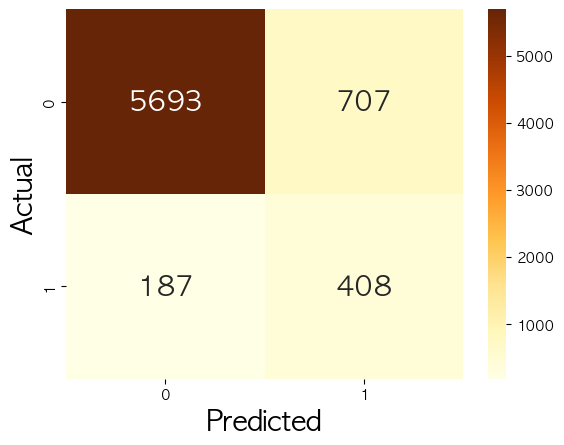

In [31]:
SVM(rfe_bad, 'rbf')

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 10.759919300605246, 'silent': 1, 'verbosity': 0}
학습 데이터 정확도 :  0.9119800848441091

예측 데이터 정확도
accuracy score : 0.833
precision score : 0.326
recall score : 0.903
f1 score : 0.479
roc score : 0.865
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.80672    0.29963 0.95126   0.45572    0.87227
0.30000   0.81487    0.30706 0.93613   0.46243    0.86986
0.40000   0.82273    0.31412 0.91597   0.46781    0.86501
0.50000   0.83317    0.32625 0.90252   0.47925    0.86462
0.60000   0.84089    0.33440 0.87899   0.48448    0.85817
0.70000   0.85061    0.34525 0.84370   0.49000    0.84747
0.80000   0.86047    0.35601 0.79160   0.49114    0.82924
0.90000   0.87906    0.38326 0.69244   0.49341    0.79442
None


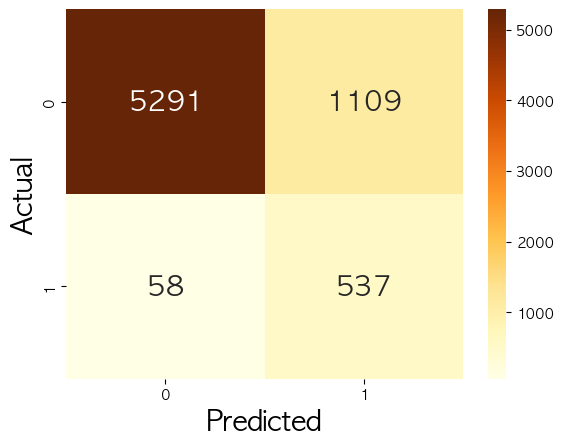

In [32]:
XGB(rfe_bad)

##### SelectFromModel_RandomForest

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8497276717968802

예측 데이터 정확도
accuracy score : 0.787
precision score : 0.269
recall score : 0.874
f1 score : 0.411
roc score : 0.827
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.47305    0.13763 0.98655   0.24156    0.70593
0.30000   0.60786    0.17455 0.96807   0.29576    0.77122
0.40000   0.71408    0.22134 0.93782   0.35815    0.81555
0.50000   0.78728    0.26901 0.87395   0.41139    0.82658
0.60000   0.83431    0.30868 0.76471   0.43983    0.80274
0.70000   0.86204    0.32280 0.56639   0.41123    0.72796
0.80000   0.87634    0.29970 0.33950   0.31836    0.63287
0.90000   0.89249    0.24759 0.12941   0.16998    0.54642
None


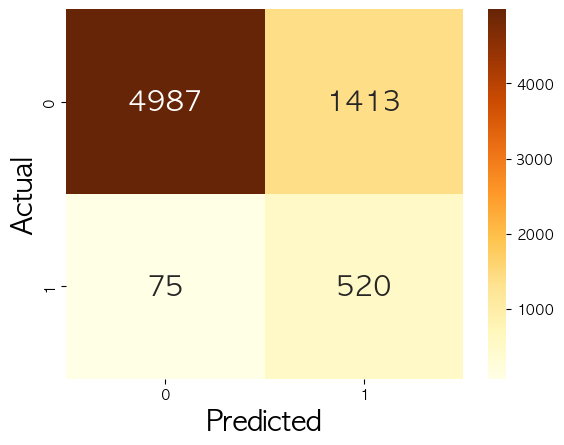

In [33]:
LR(sfm_rf_bad)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 6, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.9085177614648133

예측 데이터 정확도
accuracy score : 0.825
precision score : 0.317
recall score : 0.919
f1 score : 0.472
roc score : 0.868
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.80629    0.30063 0.96303   0.45822    0.87737
0.30000   0.81630    0.31086 0.95294   0.46879    0.87827
0.40000   0.82244    0.31651 0.93782   0.47328    0.87477
0.50000   0.82487    0.31729 0.91933   0.47176    0.86771
0.60000   0.83102    0.31827 0.86387   0.46516    0.84592
0.70000   0.87706    0.38743 0.76639   0.51467    0.82687
0.80000   0.89407    0.41531 0.60168   0.49142    0.76147
0.90000   0.90164    0.43091 0.48739   0.45741    0.71378
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

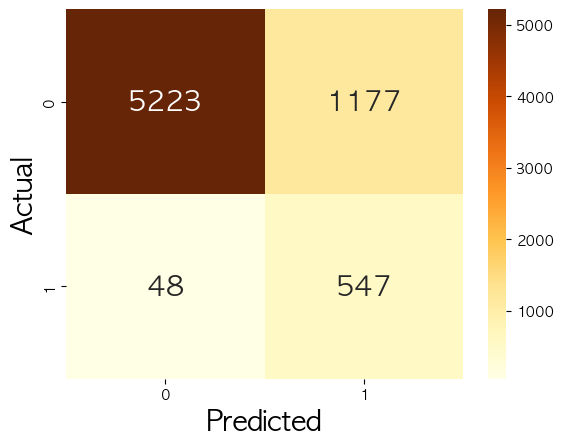

In [34]:
DT(sfm_rf_bad)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.9291021830152564

예측 데이터 정확도
accuracy score : 0.873
precision score : 0.382
recall score : 0.793
f1 score : 0.516
roc score : 0.837


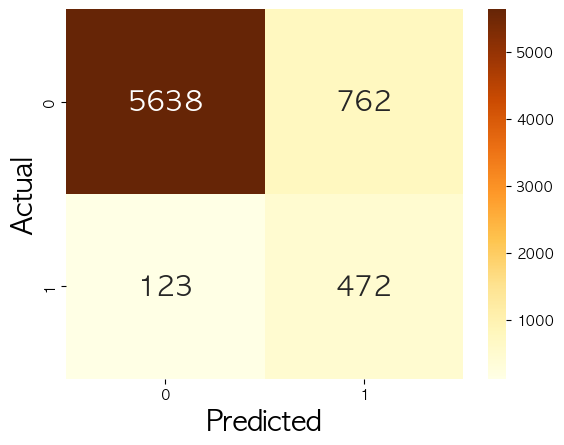

In [35]:
SVM(sfm_rf_bad, 'rbf')

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.6, 'colsample_bytree': 0.8, 'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 10.759919300605246, 'silent': 1, 'verbosity': 0}
학습 데이터 정확도 :  0.9226637913183235

예측 데이터 정확도
accuracy score : 0.855
precision score : 0.356
recall score : 0.872
f1 score : 0.506
roc score : 0.863
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.83159    0.32923 0.94454   0.48827    0.88282
0.30000   0.84174    0.34178 0.92941   0.49977    0.88150
0.40000   0.84918    0.34967 0.89916   0.50353    0.87185
0.50000   0.85518    0.35646 0.87227   0.50609    0.86293
0.60000   0.86333    0.36815 0.84706   0.51324    0.85595
0.70000   0.87248    0.38224 0.81008   0.51940    0.84418
0.80000   0.88292    0.40088 0.76134   0.52522    0.82778
0.90000   0.89993    0.44054 0.65378   0.52639    0.78830
None


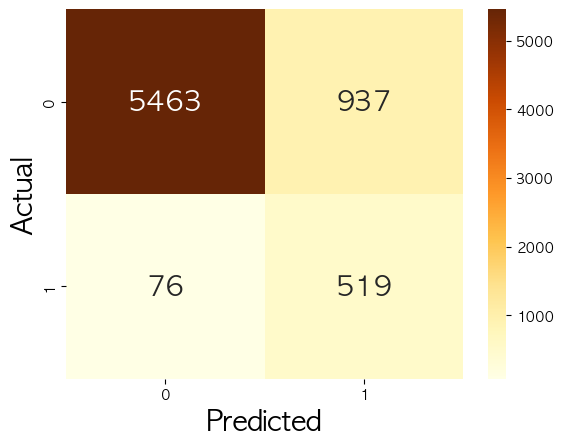

In [36]:
XGB(sfm_rf_bad)

##### SelectFromModel_Logistic Regression

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.8291843634757885

예측 데이터 정확도
accuracy score : 0.785
precision score : 0.264
recall score : 0.854
f1 score : 0.403
roc score : 0.816
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.42931    0.12891 0.99160   0.22815    0.68431
0.30000   0.59643    0.17080 0.97143   0.29053    0.76650
0.40000   0.71208    0.22012 0.93782   0.35655    0.81445
0.50000   0.78485    0.26376 0.85378   0.40301    0.81611
0.60000   0.82816    0.28732 0.68908   0.40554    0.76508
0.70000   0.85189    0.29564 0.53613   0.38112    0.70869
0.80000   0.86791    0.23596 0.24706   0.24138    0.58634
0.90000   0.89006    0.21382 0.10924   0.14461    0.53595
None


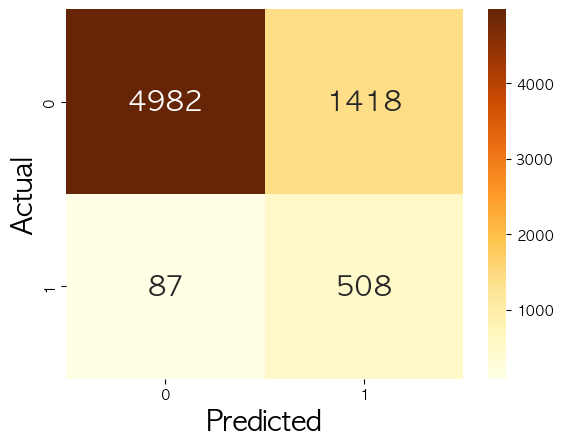

In [37]:
LR(sfm_lr_bad)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.8942823889519612

예측 데이터 정확도
accuracy score : 0.794
precision score : 0.288
recall score : 0.960
f1 score : 0.443
roc score : 0.869
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.78127    0.27770 0.98151   0.43291    0.87208
0.30000   0.78284    0.27874 0.97815   0.43384    0.87142
0.40000   0.78528    0.28039 0.97311   0.43534    0.87046
0.50000   0.79442    0.28766 0.95966   0.44264    0.86936
0.60000   0.84603    0.34061 0.86555   0.48885    0.85488
0.70000   0.84889    0.34156 0.83697   0.48514    0.84349
0.80000   0.89535    0.42842 0.68908   0.52835    0.80180
0.90000   0.92294    0.57692 0.35294   0.43796    0.66444
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

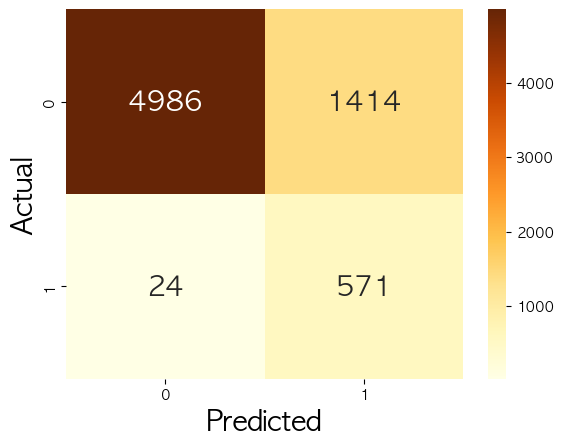

In [38]:
DT(sfm_lr_bad)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 10.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.943341464803947

예측 데이터 정확도
accuracy score : 0.909
precision score : 0.450
recall score : 0.304
f1 score : 0.363
roc score : 0.635


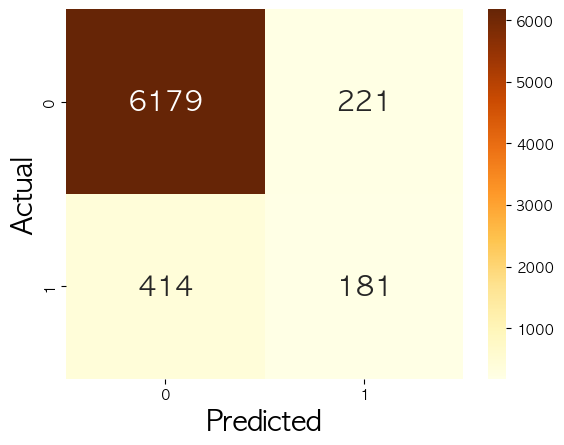

In [39]:
SVM(sfm_lr_bad, 'rbf')

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 1.0, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 10.759919300605246, 'silent': 1, 'verbosity': 0}
학습 데이터 정확도 :  0.9188521332683248

예측 데이터 정확도
accuracy score : 0.836
precision score : 0.325
recall score : 0.861
f1 score : 0.472
roc score : 0.847
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.81172    0.30380 0.93950   0.45914    0.86967
0.30000   0.81973    0.31144 0.92437   0.46590    0.86718
0.40000   0.82773    0.31780 0.89412   0.46893    0.85784
0.50000   0.83617    0.32508 0.86050   0.47189    0.84721
0.60000   0.84375    0.33244 0.83025   0.47477    0.83763
0.70000   0.85490    0.34761 0.80504   0.48555    0.83229
0.80000   0.87162    0.37510 0.76471   0.50332    0.82313
0.90000   0.89392    0.42156 0.66387   0.51567    0.78959
None


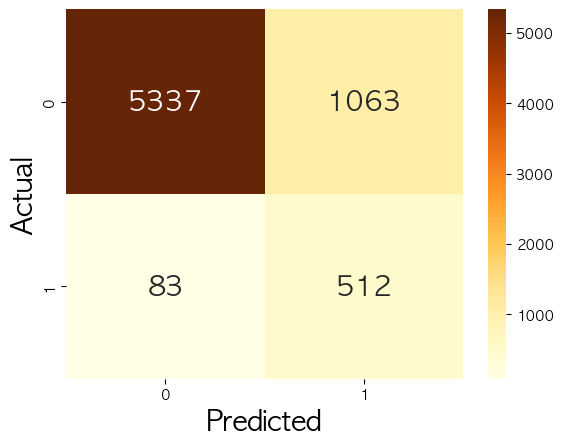

In [40]:
XGB(sfm_lr_bad)

##### Permutation Importance

최적 파라미터
 {'C': 0.001, 'class_weight': 'balanced', 'penalty': 'l1', 'random_state': 121, 'solver': 'liblinear'}
학습 데이터 정확도 :  0.850335917377507

예측 데이터 정확도
accuracy score : 0.788
precision score : 0.270
recall score : 0.876
f1 score : 0.412
roc score : 0.828
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.47291    0.13760 0.98655   0.24151    0.70586
0.30000   0.60829    0.17470 0.96807   0.29599    0.77146
0.40000   0.71480    0.22178 0.93782   0.35873    0.81594
0.50000   0.78756    0.26953 0.87563   0.41218    0.82750
0.60000   0.83402    0.30827 0.76471   0.43940    0.80259
0.70000   0.86204    0.32280 0.56639   0.41123    0.72796
0.80000   0.87605    0.29822 0.33782   0.31678    0.63195
0.90000   0.89264    0.24839 0.12941   0.17017    0.54650
None


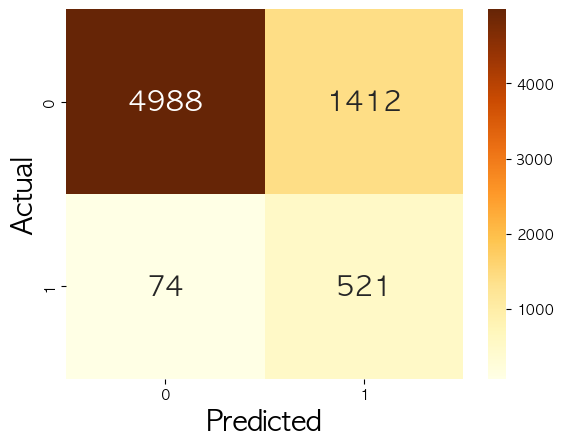

In [41]:
LR(sfm_pi_bad)

최적 파라미터
 {'class_weight': 'balanced', 'criterion': 'entropy', 'max_depth': 7, 'min_samples_split': 3, 'random_state': 121, 'splitter': 'best'}
학습 데이터 정확도 :  0.9114026020026635

예측 데이터 정확도
accuracy score : 0.844
precision score : 0.337
recall score : 0.864
f1 score : 0.485
roc score : 0.853
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.81444    0.30676 0.93782   0.46230    0.87039
0.30000   0.81487    0.30556 0.92437   0.45929    0.86453
0.40000   0.84017    0.33376 0.88235   0.48432    0.85930
0.50000   0.84375    0.33683 0.86387   0.48468    0.85287
0.60000   0.85575    0.34506 0.77479   0.47747    0.81904
0.70000   0.85861    0.34893 0.76471   0.47920    0.81602
0.80000   0.88320    0.37500 0.55966   0.44909    0.73647
0.90000   0.88935    0.37196 0.43697   0.40185    0.68419
None


GridSearchCV(cv=5, estimator=DecisionTreeClassifier(), n_jobs=-1,
             param_grid={'class_weight': ['balanced'], 'criterion': ['entropy'],
                         'max_depth': [5, 6, 7], 'min_samples_split': [3, 5],
                         'random_state': [121], 'splitter': ['best']},
             scoring='f1')

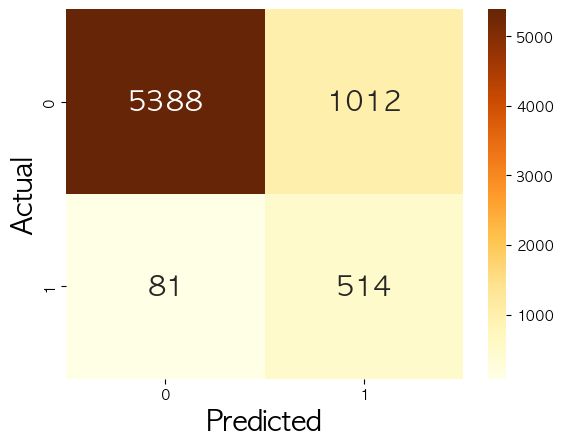

In [42]:
DT(sfm_pi_bad)

최적 파라미터
 {'C': 1.0, 'class_weight': 'balanced', 'gamma': 1.0, 'kernel': 'rbf', 'random_state': 121}
학습 데이터 정확도 :  0.9228569325492272

예측 데이터 정확도
accuracy score : 0.861
precision score : 0.358
recall score : 0.802
f1 score : 0.495
roc score : 0.834


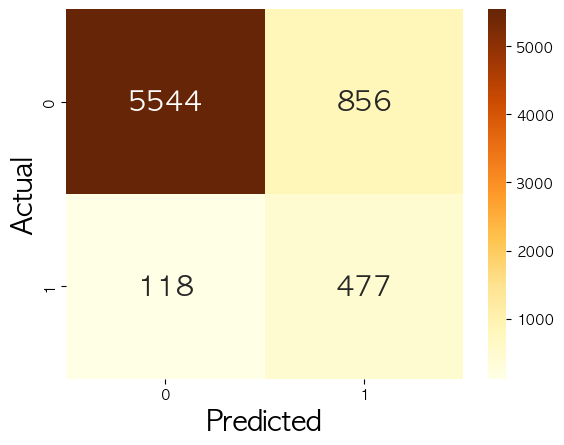

In [43]:
SVM(sfm_pi_bad, 'rbf')

최적 파라미터
 {'booster': 'gbtree', 'colsample_bylevel': 0.8, 'colsample_bytree': 0.8, 'gamma': 0.1, 'learning_rate': 0.1, 'max_depth': 6, 'min_child_weight': 3, 'n_estimators': 500, 'objective': 'binary:logistic', 'random_state': 121, 'scale_pos_weight': 10.759919300605246, 'silent': 1, 'verbosity': 0}
학습 데이터 정확도 :  0.9230855197136494

예측 데이터 정확도
accuracy score : 0.855
precision score : 0.357
recall score : 0.881
f1 score : 0.508
roc score : 0.867
         Accuracy  Precision  Recall  F1 score  Auc_Score
0.20000   0.83231    0.33119 0.95294   0.49155    0.88702
0.30000   0.83960    0.33824 0.92605   0.49550    0.87881
0.40000   0.84589    0.34529 0.90588   0.50000    0.87310
0.50000   0.85475    0.35671 0.88067   0.50775    0.86651
0.60000   0.86176    0.36522 0.84706   0.51038    0.85509
0.70000   0.87134    0.37983 0.81008   0.51717    0.84356
0.80000   0.88220    0.40052 0.77479   0.52806    0.83349
0.90000   0.89664    0.43043 0.66555   0.52277    0.79184
None


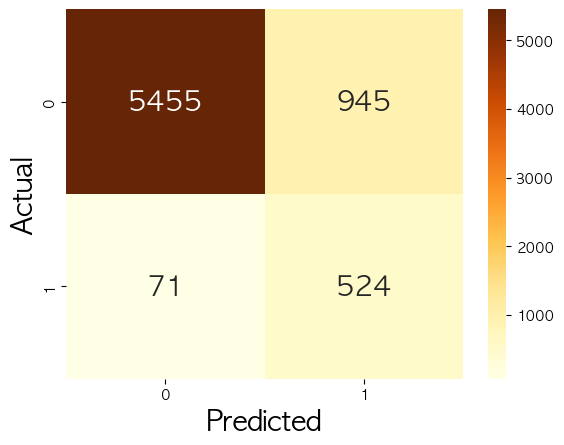

In [44]:
XGB(sfm_pi_bad)